### A. Community Detection

#### 1. Finding cliques

In [1]:
# Install libraries for Louvain method and partition
!pip install python-louvain
!pip install community

# Construct a the karate graph



#### 1.1. Building a k_cliques function to find cliques size k

In [2]:
from itertools import combinations
import networkx as nx

def k_cliques(graph):
    # 2-cliques
    cliques = [{i, j} for i, j in graph.edges() if i != j]
    k = 2

    while cliques:
        # result
        yield k, cliques

        # merge k-cliques into (k+1)-cliques
        cliques_1 = set()
        for u, v in combinations(cliques, 2):
            w = u ^ v
            if len(w) == 2 and graph.has_edge(*w):
                cliques_1.add(tuple(u | w))

        # remove duplicates
        cliques = list(map(set, cliques_1))
        k += 1


def print_cliques(graph, size_k):
    for k, cliques in k_cliques(graph):
        if k == size_k:
            print('Size %d-cliques = %d, %s.' % (k, len(cliques), cliques))

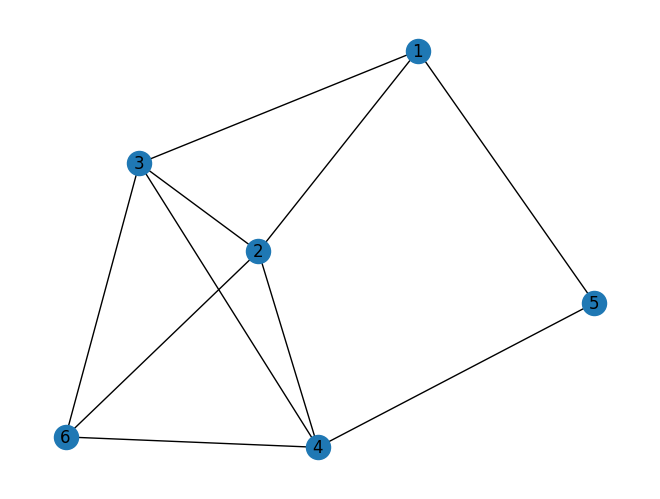

In [51]:
#Construct  NetworkX graph
graph = nx.Graph()
nodes, edges = 6, 10
size_k = 3

graph.add_edge(1, 2)
graph.add_edge(1, 3)
graph.add_edge(1, 5)
graph.add_edge(2, 3)
graph.add_edge(2, 4)
graph.add_edge(2, 6)
graph.add_edge(3, 4)
graph.add_edge(3, 6)
graph.add_edge(4, 5)
graph.add_edge(4, 6)
nx.draw(graph,with_labels=True)

In [4]:
print_cliques(graph, size_k)

Size 3-cliques = 5, [{3, 4, 6}, {2, 3, 6}, {1, 2, 3}, {2, 3, 4}, {2, 4, 6}].


#### 1.2. Finding k-cliques in real graph (karate graph)

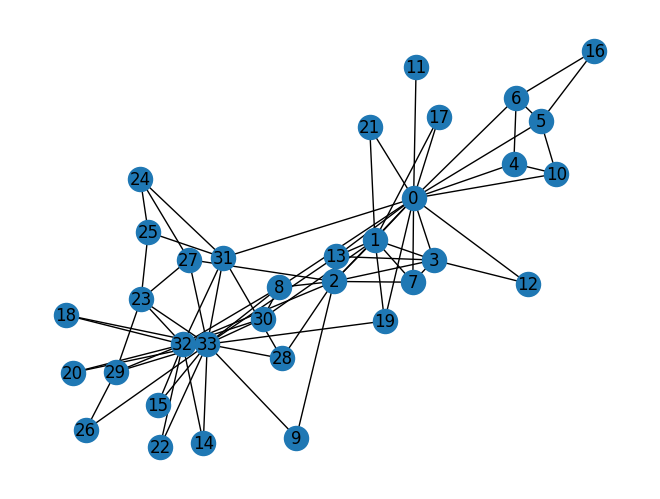

In [5]:
import networkx as nx

g = nx.karate_club_graph()
nx.draw(g,with_labels=True)


#### Find all cliques of 4 or more

In [6]:
cliques = nx.find_cliques(g)
cliques4 = [clq for clq in cliques if len(clq) >= 4]
cliques4

[[0, 1, 2, 3, 13], [0, 1, 2, 3, 7], [33, 32, 8, 30], [33, 32, 23, 29]]

#### 1.3. Finding subgraph with size k

(construct the subgraph: degree of nodes >=4)

In [7]:
nodes = set(n for clq in cliques4 for n in clq)
h = g.subgraph(nodes)

#### Drop nodes of subgraph which have degree less than 4:

In [8]:
deg = nx.degree(h)
nodes = [n for n in nodes if deg[n] >= 4]

In [9]:
#construct the subgraph: degree of nodes >=4
k = h.subgraph(nodes)


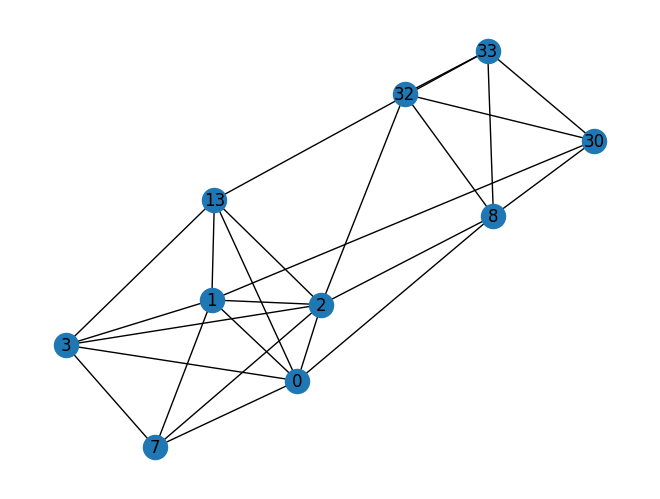

In [10]:
# Visualizing subgraph

nx.draw(k,with_labels=True)

#### 2. Graph partition

#### 2.1. Finding communities based on a given partition


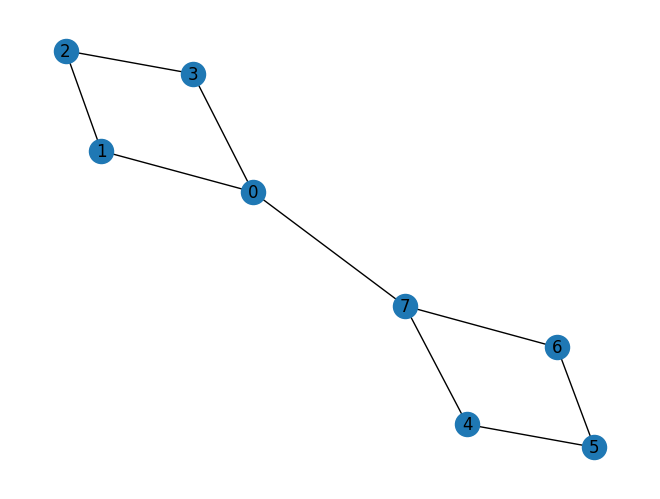

In [11]:
# Construct a graph as follow:

G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

In [12]:
# Define a partition of graph:

partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

In [13]:
# Checking: Returns True if communities is a partition of the nodes of G.

nx.community.is_partition(G, partition)


True

In [14]:
# Mapping all nodes to each partition

partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In [15]:
# Checking nodes 0 and 7 are in the same partition?

partition_map[0] == partition_map[7]


True

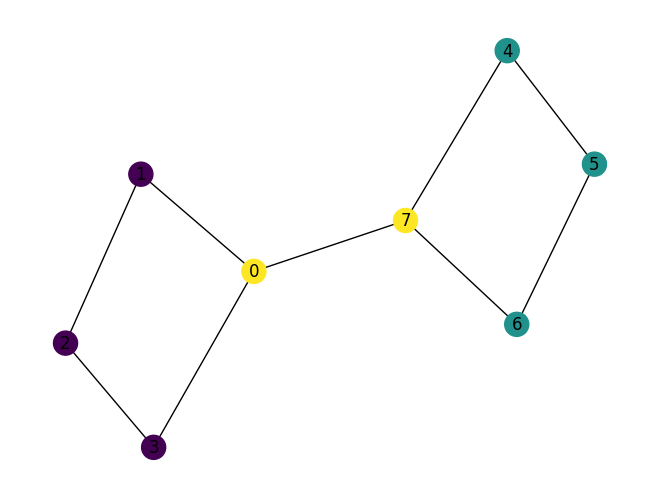

In [16]:
# Coloring nodes in each partition

node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

#### 3. Building a Modularity function and finding communities

#### In the Community library, the module modularity is a greedy modularity. Let's compare the manual Modularity with the library

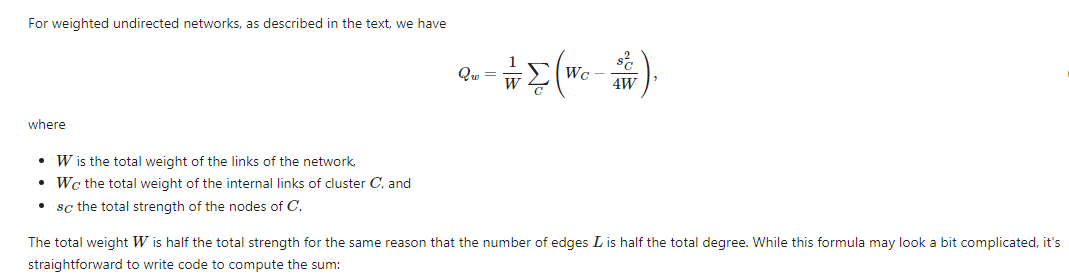

In [17]:
# define a modularity function

def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [18]:
# pre-define a partition

partition = [
    {0,1, 2, 3},
    {4, 5, 6,7},
]

modularity(G, partition)

0.3888888888888889

In [19]:
## For Community Detection (Louvain Method)
import community
partition = community.best_partition(G)
partition

{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1}

#### Compare the modularity module with community library

In [20]:
import community as comm
bp = comm.best_partition(G)
comm.modularity(bp,G)

0.38888888888888884

#### Let's compare this to a partition we would suspect to have higher modularity:


In [21]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)


0.3888888888888889

#### NetworkX function comparision


In [22]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

#### 4. Finding comunities based on Louvain algorithm


#### Load the Karate Graph from NetworkX

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np

In [24]:
# Checking the graph information

def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Available nodes:", list(graph.nodes))
    print("Available edges:", list(graph.edges))
    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(directed_graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))

In [25]:
# built-in graph from networkx
karate_graph = nx.karate_club_graph()
get_graph_info(karate_graph)

Number of nodes: 34
Number of edges: 78
Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Available edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [26]:
# club color reference
nation_color_dict = {
    'Mr. Hi': '#aff8df',
    'Officer': '#ffcbc1'
}

# function to assign color for node visualization
def create_node_colors_from_graph(graph, club_color_dict):
    node_colors = []
    for node, club in list(graph.nodes(data="club")):
        if club in club_color_dict:
            node_colors.append(club_color_dict[club])
    return node_colors

# get node colors for plotting
node_colors = create_node_colors_from_graph(karate_graph, nation_color_dict)


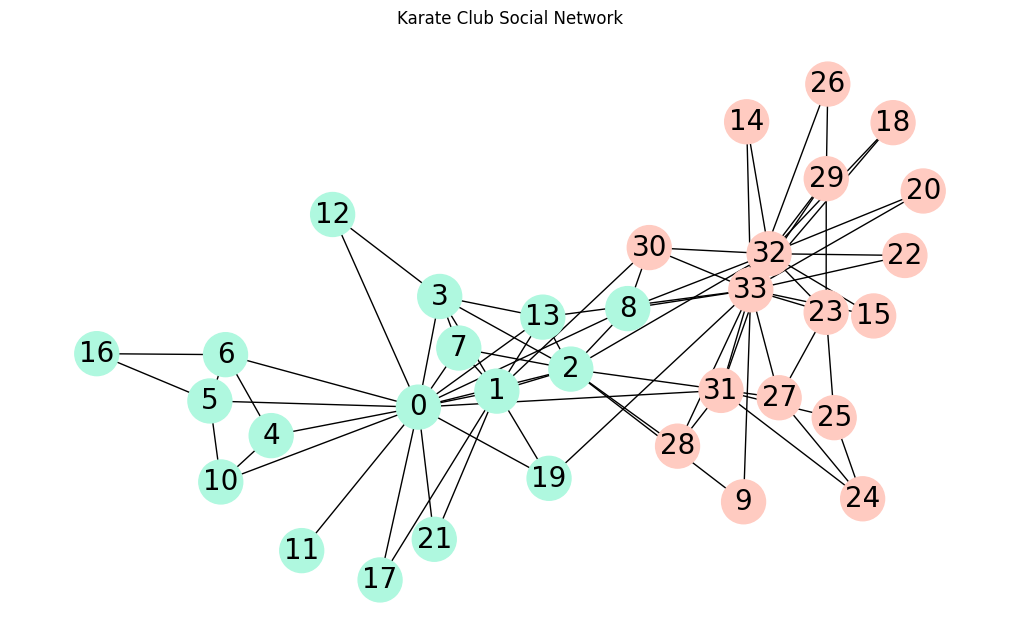

In [27]:
# create visualization
pos = nx.spring_layout(karate_graph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(10,6)) 
nx.draw(karate_graph,
        pos = pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        font_size = 20,
        font_color='black')
plt.title("Karate Club Social Network")
plt.show()

In [28]:
# Import libraries
import community.community_louvain as community_louvain
import networkx.algorithms.community as nx_comm


In [29]:
# Construct node colours for each community
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

In [30]:
# convert the python-louvain package output to 
# NetworkX package community function output format
def get_louvain_communities(graph, random_state=1):
    louvain_partition_dict = community_louvain.best_partition(graph, random_state=random_state)
    unique_partition_labels = list(set(louvain_partition_dict.values()))
    communities = [[] for i in range(len(unique_partition_labels))]
    for node in louvain_partition_dict.keys():
        communities[louvain_partition_dict[node]].append(node)
    return communities

In [31]:
# get communities using louvain algorithm
louvain_communities = get_louvain_communities(karate_graph, random_state=1)
louvain_communities

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [4, 5, 6, 10, 16],
 [24, 25, 28, 31],
 [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]]

In [32]:
# Visualize communities
def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

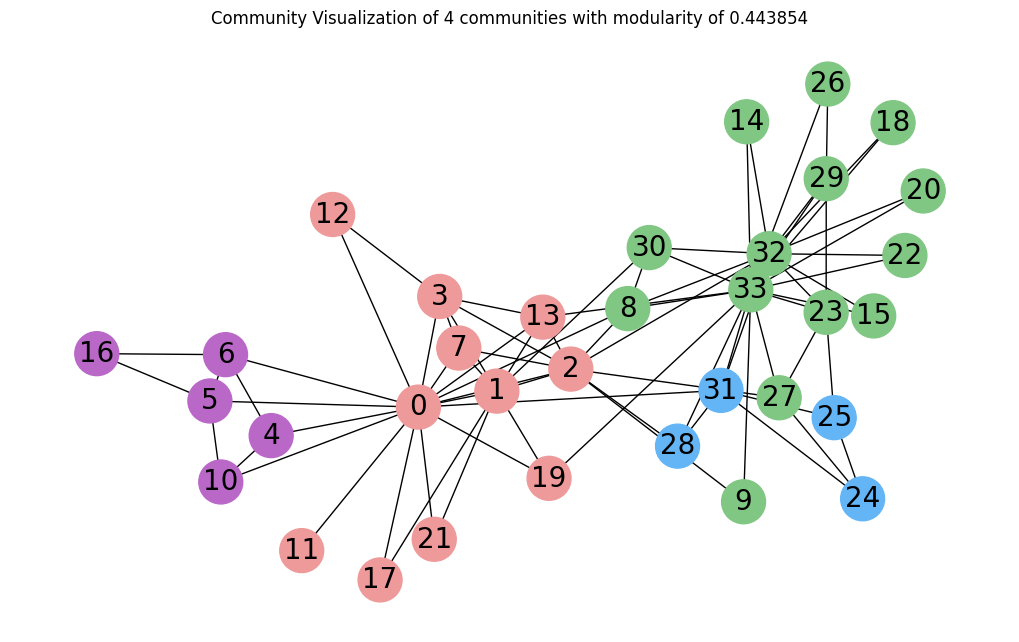

In [33]:
visualize_communities(karate_graph, louvain_communities)


#### Let's visualize the subgraphs

In [34]:
# visualizing all subgraphs
def visualize_subgraph(graph, subgraph_nodes, node_color):
    # get subgraph
    subgraph = nx.subgraph(graph, subgraph_nodes)

    # create visualization
    node_colors = [node_color] * len(subgraph_nodes)
    title = f"Community Partition Subgraph"
    pos = nx.spring_layout(subgraph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(8,6)) 
    nx.draw(subgraph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

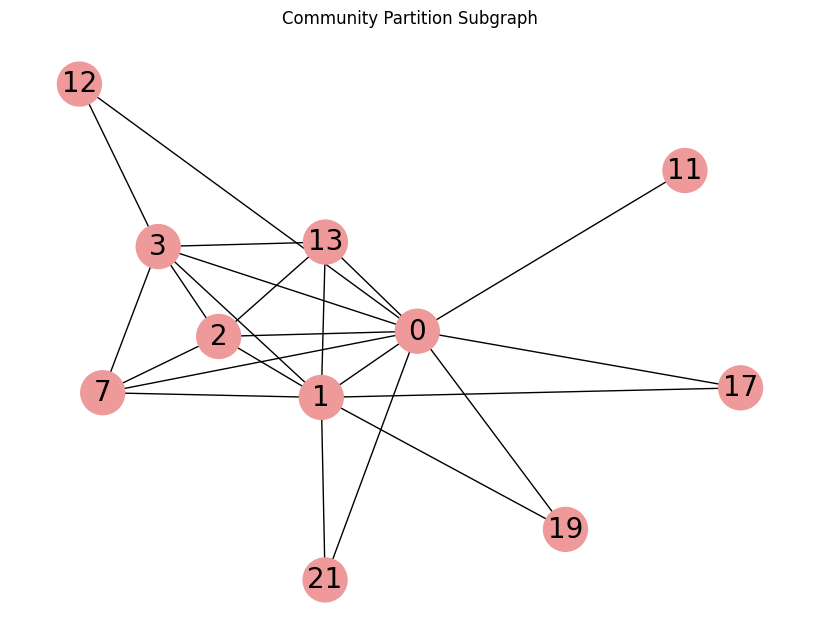

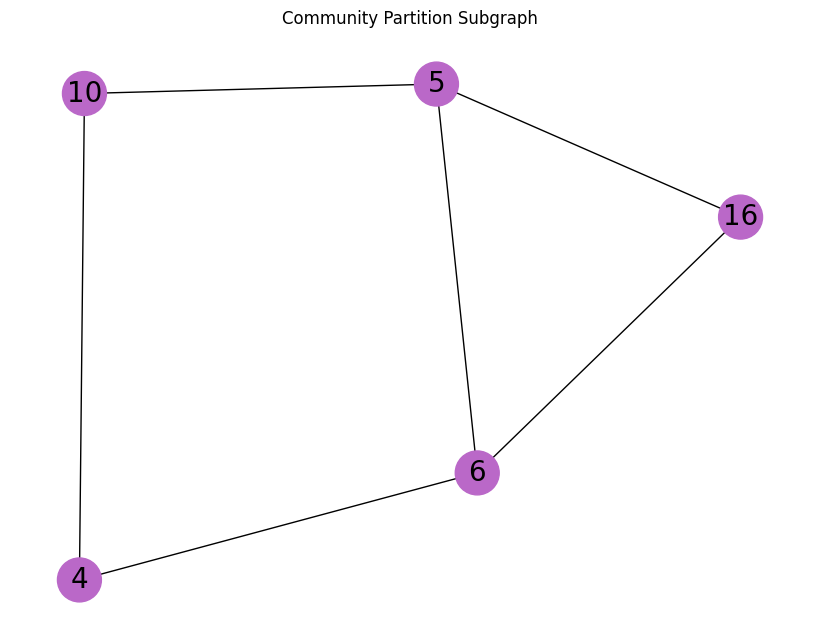

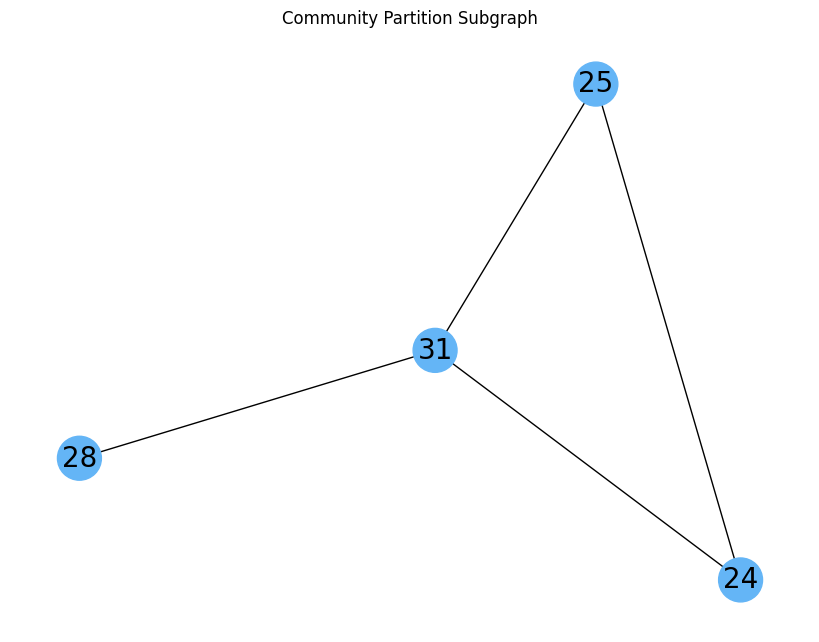

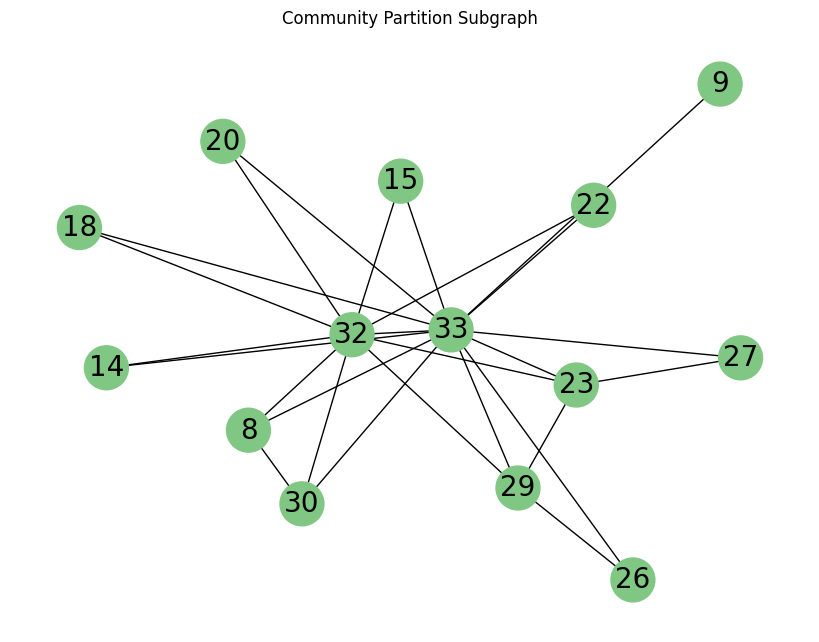

In [35]:
# Colouring each subgraph with a individual colour
colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784", "#FFF176", "#BDBDBD"]
for i in range(len(louvain_communities)):
    visualize_subgraph(karate_graph, louvain_communities[i], colors[i])

### B. Link Prediction

We will take the Karate Club example and start with link prediction with jaccard_coefficient measurement

In [36]:
!pip install networkx pandas numpy matplotlib

import networkx as nx
import numpy as np
import pandas as pd
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt

C:\Users\user\anaconda3\envs\test\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


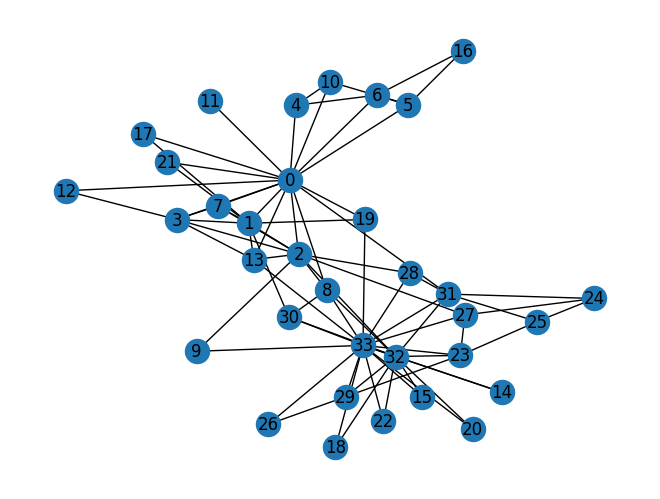

In [37]:
n=34
m = 78
G_karate = nx.karate_club_graph()

pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

In [38]:
n = G_karate.number_of_nodes()
m = G_karate.number_of_edges()
print("Number of nodes : %d" % n)
print("Number of edges : %d" % m)
print("Number of connected components : %d" % nx.number_connected_components(G_karate))

Number of nodes : 34
Number of edges : 78
Number of connected components : 1


#### Let remove some connections (0,1):

In [39]:
# Remove 20% of the edges
proportion_edges = 0.2
#edge_subset = random.sample(G_karate.edges(), int(proportion_edges * G_karate.number_of_edges()))

edge_subset = [(0,1)]

# Create a copy of the graph and remove the edges
G_karate_train = G_karate.copy()
G_karate_train.remove_edges_from(edge_subset)

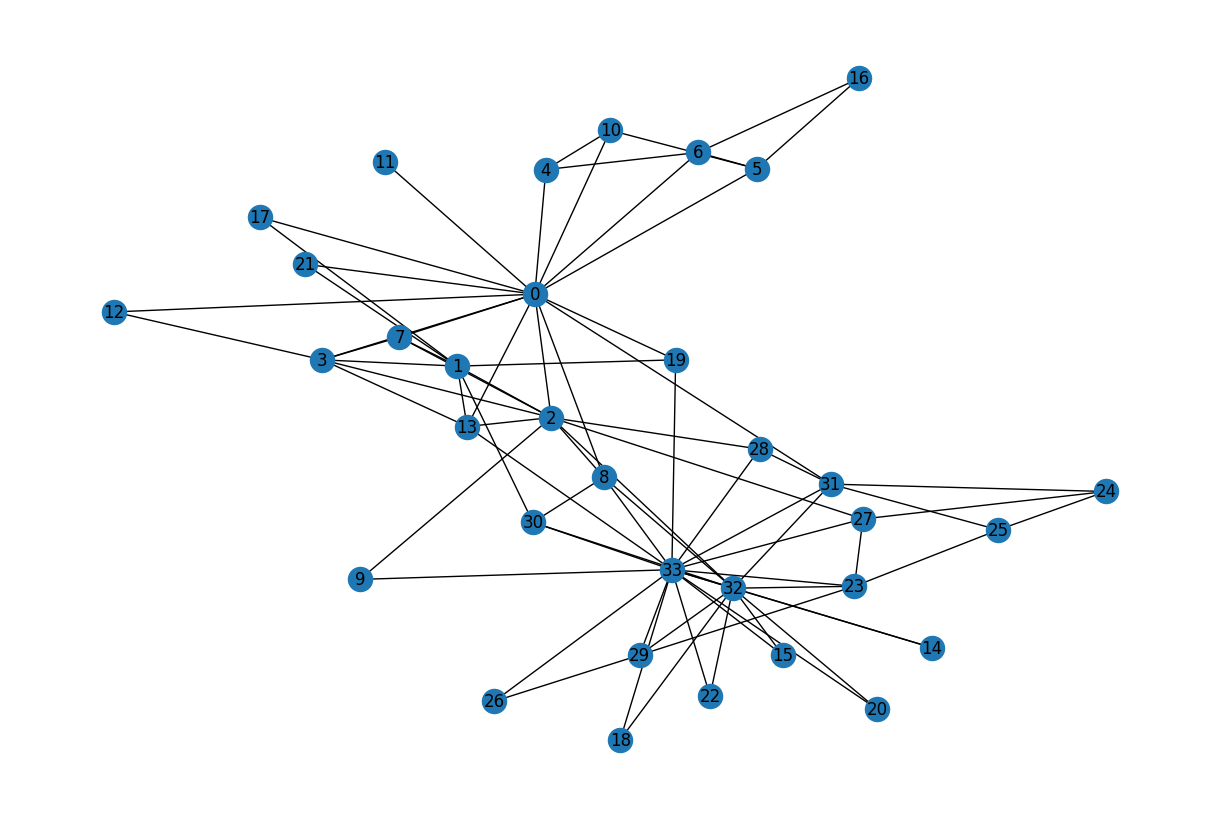

In [40]:
plt.figure(figsize=(12,8))
nx.draw(G_karate_train, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

#### Check the edge (u, v) is in the graph.

In [41]:
G_karate_train.has_edge(0, 1)

False

#### 2.1. Jaccard Coefficient

In [42]:
# Make prediction using Jaccard Coefficient
pred_jaccard = list(nx.jaccard_coefficient(G_karate_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])

In [43]:
import numpy as np
l = np.array(pred_jaccard).shape[0]
l

484

In [44]:
def get_all_link(nod_id, list_pre):
    arr= []
    for i in range(l):
        if pred_jaccard[i][nod_id] == 0:
            arr.append(pred_jaccard[i])
    return arr

#### Lets predict the link between from node 0 to remaining nodes. We can see that the score between node pair(0,1) is highest. 

It means that two nodes are connected

In [45]:
get_all_link(0, pred_jaccard)

[(0, 32, 0.125),
 (0, 1, 0.4375),
 (0, 33, 0.14285714285714285),
 (0, 9, 0.0625),
 (0, 14, 0.0),
 (0, 15, 0.0),
 (0, 16, 0.13333333333333333),
 (0, 18, 0.0),
 (0, 20, 0.0),
 (0, 22, 0.0),
 (0, 23, 0.0),
 (0, 24, 0.058823529411764705),
 (0, 25, 0.058823529411764705),
 (0, 26, 0.0),
 (0, 27, 0.05555555555555555),
 (0, 28, 0.125),
 (0, 29, 0.0),
 (0, 30, 0.05555555555555555)]

#### 2.2. Common neighbors

In [46]:
# Function to get common values in two lists
def common_values(a, b):
    a_set = set(a)
    b_set = set(b)
    
    return list(a_set & b_set)

# Function to get list of common neighbors
def get_common_neighbors(G, node_list):
    cn_list = G.nodes
    node_pairs = [(a, b) for idx, a in enumerate(node_list) for b in node_list[idx + 1:]]
    
    for pair in node_pairs:
        cn_in_node_pair = sorted(nx.common_neighbors(G, pair[0], pair[1]))
        cn_list = common_values(cn_list, cn_in_node_pair)

    return cn_list




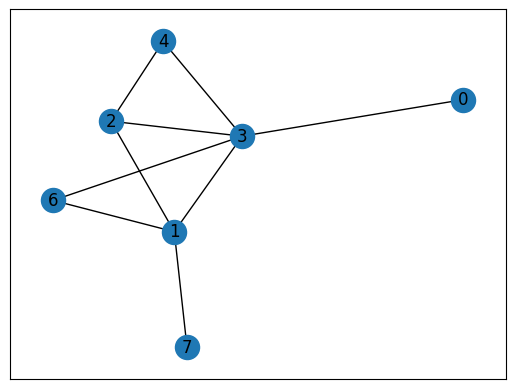

In [47]:
import networkx as nx
G = nx.Graph()
edges = [(1, 2), (2, 3), (1, 3), (3, 4), (3, 0),(1, 7),(4, 2),(3,6),(6,1)]
G.add_edges_from(edges)
nx.draw_networkx(G)


Common neighbors of [3, 6]: [1]


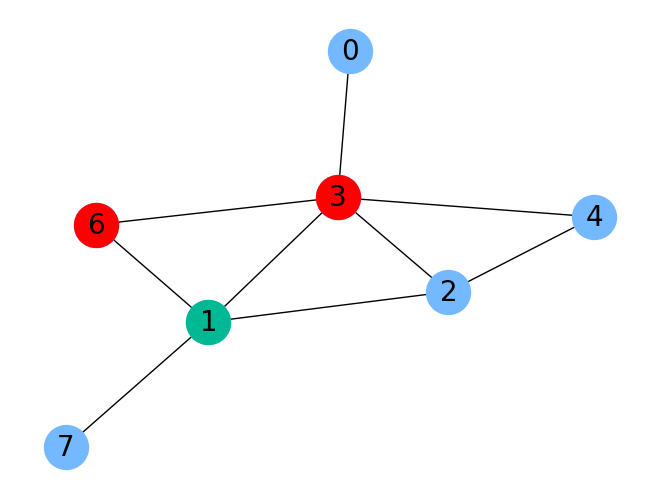

In [48]:

# Relabel nodes from string to int
mapping = {f'{i}': i for i in range(11)}
G = nx.relabel_nodes(G, mapping)

# Choose list of nodes to get common neighbors
target_nodes = [3, 6]

# Get list of common neighbors
cn_list = get_common_neighbors(G, target_nodes)

print(f"Common neighbors of {target_nodes}: {cn_list}")

pos = nx.spring_layout(G)
nx.draw(G, pos,
        node_size=1000,
        node_color='#74b9ff',
        with_labels=True,
        font_size = 20)

# Mark common neighbors as green color
nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=cn_list, node_color='#00b894')

# Mark target nodes as red color
nx.draw_networkx_nodes(G, pos, node_size=1000, nodelist=target_nodes, node_color='r')

#### Jaccard’s coefficient

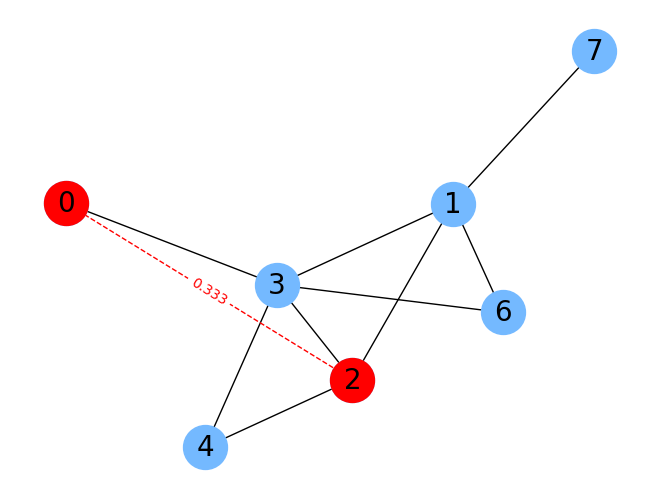

In [49]:
# Draw graph with coefficient edges
def draw_coefficient_edges(G, preds):
    edge_labels = {}
    target_list = []

    for u, v, p in preds:
        edge_labels[(u, v)] = f"{p:.3f}"
        target_list.append(u)
        target_list.append(v)
        
    pos = nx.spring_layout(G)

    nx.draw(G, pos, 
            node_size=1000,
            node_color='#74b9ff',
            with_labels=True,
            font_size = 20)
    # Mark target nodes as green color
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=target_list,
                           node_size=1000,
                           node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=node_list, style='dashed', edge_color='r')

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='red'
    )

# Calculate Jaccard’s coefficient of node pairs in a list of nodes
node_list = [(0, 2)]
preds = nx.jaccard_coefficient(G, node_list)
draw_coefficient_edges(G, preds)

#### SimRank similarity

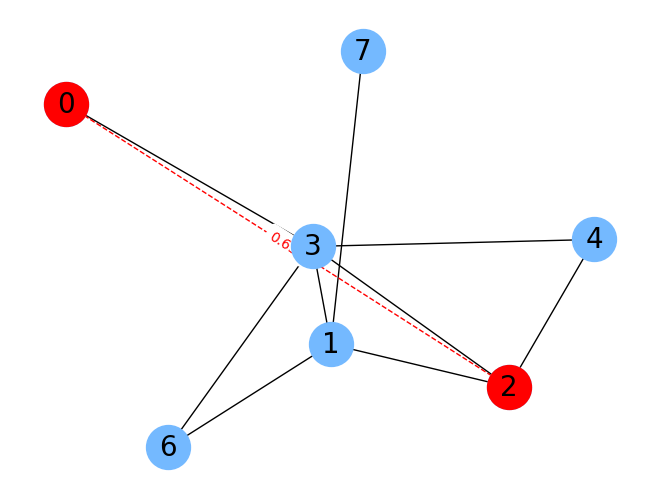

In [50]:
# Function to calculate SimRank similarity of a list of node pairs
def calculate_simrank_similarity(G, node_list):
    return ((source, target, nx.simrank_similarity(G, source, target)) for source, target in node_list)

node_list =  [ (0, 2)]
preds = calculate_simrank_similarity(G, node_list)

draw_coefficient_edges(G, preds)  